C:\Users\luisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\_lib\_util.py:714: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for el in a.ravel():
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\354975997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\354975997.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

R²: 0.9140352164004398
MSE: 5993500.319898479
MAE: 1453.8350851196626
Durchschnittspreis: 13760.999147000284
       Actual  Predicted
61506   14980   15688.05
1631     3900    3210.03
10247    4600    5016.53
9183     4150    3551.83
53760   13490   13216.58
...       ...        ...
44184   11990    8972.14
37994   11900   13020.47
41106   13900   14388.27
6032     3750    3007.35
16451   22500   23209.55

[704 rows x 2 columns]
                       Feature  Importance
2                        Alter    0.770561
1                     power_ps    0.120872
3                mileage_in_km    0.065609
0                    Verbrauch    0.023163
4     transmission_type_Manual    0.010017
5  transmission_type_Automatic    0.009778


C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\354975997.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie


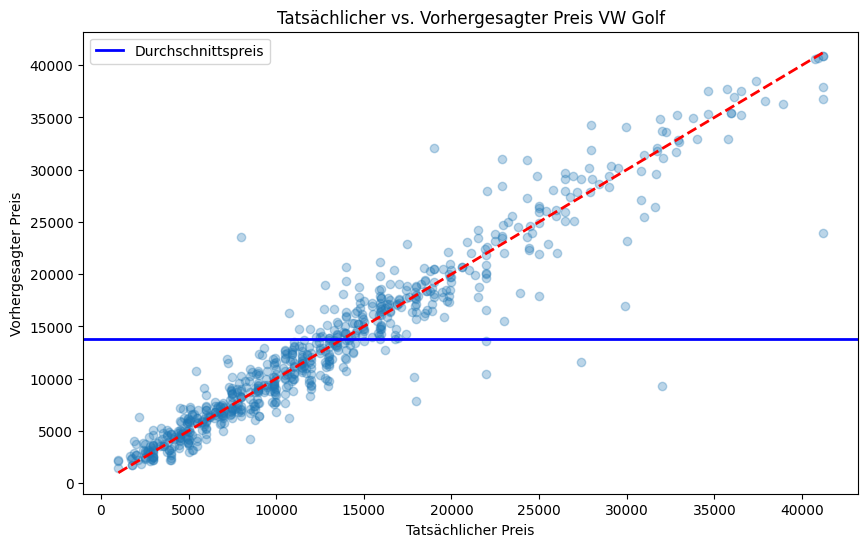

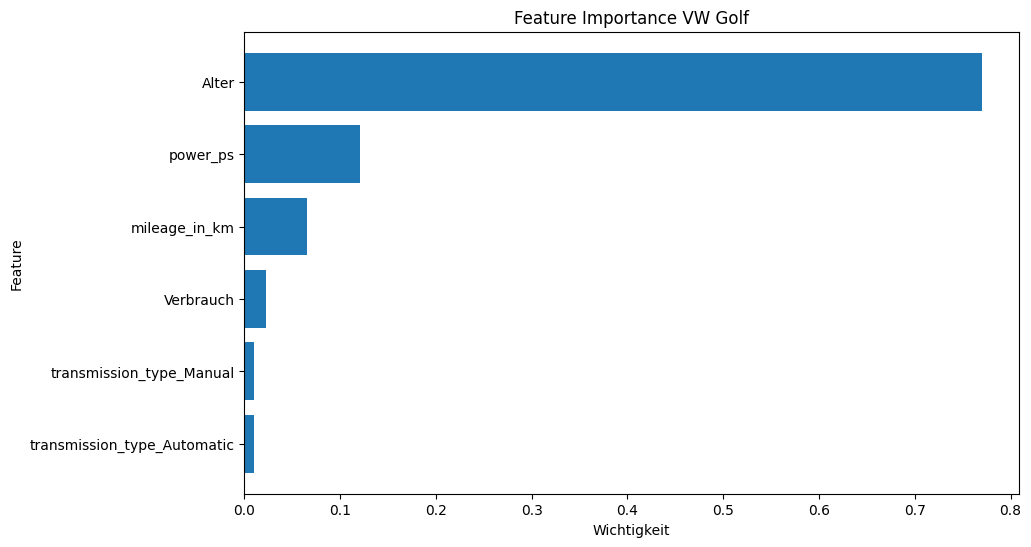

In [10]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

file_path = 'C:\\Desktop\\Datensätze Reg\\DatensatzRegR.csv'

df = pd.read_csv(file_path, delimiter=";")

# kategorische in numerische Variablen umwandeln
df = pd.get_dummies(df, columns=['brand', 'model', 'color', 'transmission_type', 'fuel_type'])

# Filtern des DataFrames nach gewünschtem Automodell
df_filtered = df[(df['model_Volkswagen Golf'] == 1)]
                 
# Winsorizing der Spalten 'Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', und 'price_in_euro' 
df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
df_filtered['power_ps'] = winsorize(df_filtered['power_ps'], limits=[0.01, 0.01])
df_filtered['Alter'] = winsorize(df_filtered['Alter'], limits=[0.01, 0.01])
df_filtered['mileage_in_km'] = winsorize(df_filtered['mileage_in_km'], limits=[0.01, 0.01])
df_filtered['price_in_euro'] = winsorize(df_filtered['price_in_euro'], limits=[0.01, 0.01])

# Konvertierung der Spalten, die Kommas als Dezimaltrennzeichen verwenden könnten
columns_to_convert = ['Verbrauch', 'Alter']

for column in columns_to_convert:
    if column in df_filtered.columns:
        df_filtered[column] = df_filtered[column].astype(str).str.replace(',', '.').astype(float)

# Begrenzen des Kilometerstandes, Alters und der Preisrange auf vernünftige Bereiche
df_filtered = df_filtered[(df_filtered['mileage_in_km'] >= 0) & (df_filtered['mileage_in_km'] <= 200000)]
df_filtered = df_filtered[(df_filtered['price_in_euro'] >= 500) & (df_filtered['price_in_euro'] <= 70000)]

df_filtered = df_filtered.dropna()

# relevante Features und die Zielvariable auswählen
X = df_filtered[['Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', 'transmission_type_Manual', 'transmission_type_Automatic']]
y = df_filtered['price_in_euro']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisiere und trainiere den Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen treffen + Modell bewerten
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
average_price = df_filtered['price_in_euro'].mean()

print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"Durchschnittspreis: {average_price}")


# DF mit den tatsächlichen und den vorhergesagten Werten erstellen
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Feature Importance anzeigen
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, importance)), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Prediction df + Feature importance ausgeben
print(predictions_df)
print(feature_importance)

# Visualisierung der tatsächlichen gegen die vorhergesagten Werte + Durchschnittswert als Gerade
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie
plt.axhline(y=average_price, color='blue', linestyle='-', lw=2, label='Durchschnittspreis')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis')
plt.title('Tatsächlicher vs. Vorhergesagter Preis VW Golf')
plt.legend()
plt.show()

# Visualisierung der Feature Importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature Importance VW Golf')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben zu haben
plt.show()

#predictions_df.to_excel('C:\\Desktop\\Datensätze Reg\\preddf\\predictionsdf.xlsx')


C:\Users\luisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\_lib\_util.py:714: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for el in a.ravel():
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\1918535028.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\1918535028.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

R²: 0.934124142331249
MSE: 4057283.6702404665
MAE: 1323.0974351333296
Durchschnittspreis: 12309.03680981595
        Actual     Predicted
104088   17450  17375.320000
19701     6980   5203.750000
41472     9490   9072.380000
36351     8200   8186.970000
96728    16690  16414.713333
...        ...           ...
8590      3100   2054.160000
129362   25590  25590.000000
126863   26890  26868.580000
15440     2900   4483.300000
103669   12980  13763.460000

[424 rows x 2 columns]
                       Feature  Importance
2                        Alter    0.765764
3                mileage_in_km    0.193663
1                     power_ps    0.018097
0                    Verbrauch    0.017897
4     transmission_type_Manual    0.002326
5  transmission_type_Automatic    0.002253


C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\1918535028.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie


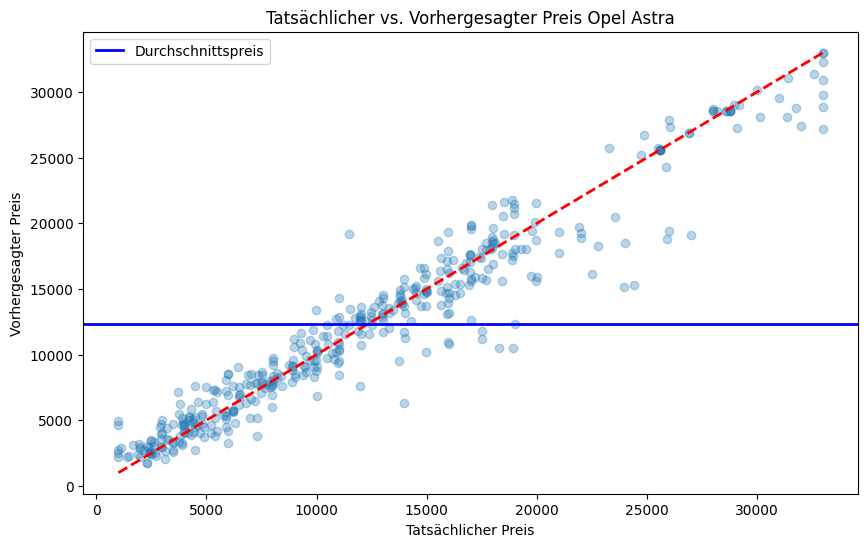

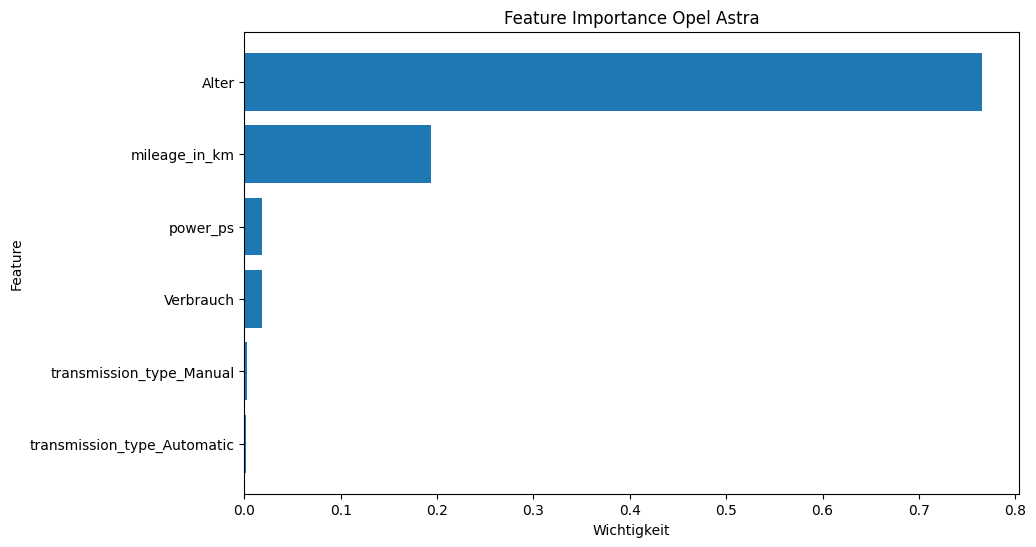

In [9]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

file_path = 'C:\\Desktop\\Datensätze Reg\\DatensatzRegR.csv'

df = pd.read_csv(file_path, delimiter=";")

# kategorische in numerische Variablen umwandeln
df = pd.get_dummies(df, columns=['brand', 'model', 'color', 'transmission_type', 'fuel_type'])

# Filtern des DataFrames nach gewünschtem Automodell
df_filtered = df[(df['model_Opel Astra'] == 1)]
                 
# Winsorizing der Spalten 'Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', und 'price_in_euro' 
df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
df_filtered['power_ps'] = winsorize(df_filtered['power_ps'], limits=[0.01, 0.01])
df_filtered['Alter'] = winsorize(df_filtered['Alter'], limits=[0.01, 0.01])
df_filtered['mileage_in_km'] = winsorize(df_filtered['mileage_in_km'], limits=[0.01, 0.01])
df_filtered['price_in_euro'] = winsorize(df_filtered['price_in_euro'], limits=[0.01, 0.01])

# Konvertierung der Spalten, die Kommas als Dezimaltrennzeichen verwenden könnten
columns_to_convert = ['Verbrauch', 'Alter']

for column in columns_to_convert:
    if column in df_filtered.columns:
        df_filtered[column] = df_filtered[column].astype(str).str.replace(',', '.').astype(float)

# Begrenzen des Kilometerstandes, Alters und der Preisrange auf vernünftige Bereiche
df_filtered = df_filtered[(df_filtered['mileage_in_km'] >= 0) & (df_filtered['mileage_in_km'] <= 200000)]
df_filtered = df_filtered[(df_filtered['price_in_euro'] >= 500) & (df_filtered['price_in_euro'] <= 70000)]

df_filtered = df_filtered.dropna()

# relevante Features und die Zielvariable auswählen
X = df_filtered[['Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', 'transmission_type_Manual', 'transmission_type_Automatic']]
y = df_filtered['price_in_euro']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisiere und trainiere den Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen treffen + Modell bewerten
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
average_price = df_filtered['price_in_euro'].mean()

print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"Durchschnittspreis: {average_price}")


# DF mit den tatsächlichen und den vorhergesagten Werten erstellen
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Feature Importance anzeigen
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, importance)), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Prediction df + Feature importance ausgeben
print(predictions_df)
print(feature_importance)

# Visualisierung der tatsächlichen gegen die vorhergesagten Werte + Durchschnittswert als Gerade
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie
plt.axhline(y=average_price, color='blue', linestyle='-', lw=2, label='Durchschnittspreis')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis')
plt.title('Tatsächlicher vs. Vorhergesagter Preis Opel Astra')
plt.legend()
plt.show()

# Visualisierung der Feature Importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature Importance Opel Astra')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben zu haben
plt.show()

#predictions_df.to_excel('C:\\Desktop\\Datensätze Reg\\preddf\\predictionsdf.xlsx')


C:\Users\luisf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\_lib\_util.py:714: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  for el in a.ravel():
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\3837636971.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\3837636971.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

R²: 0.9302027562125633
MSE: 3639423.976273239
MAE: 1240.044610996153
Durchschnittspreis: 11012.754000914494
        Actual     Predicted
119268   21470  19385.536281
81314    10860  11416.520000
36760     7599   7275.370000
102224   16899  16022.000000
53008    11900  13144.580000
...        ...           ...
102677   16980  17742.960000
6708      3695   2953.160000
106992   14390  16948.150000
102703   16890  16111.600000
42838     6899   7713.180000

[438 rows x 2 columns]
                       Feature  Importance
2                        Alter    0.920736
3                mileage_in_km    0.040154
0                    Verbrauch    0.015879
1                     power_ps    0.012839
5  transmission_type_Automatic    0.005261
4     transmission_type_Manual    0.005131


C:\Users\luisf\AppData\Local\Temp\ipykernel_36480\3837636971.py:77: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie


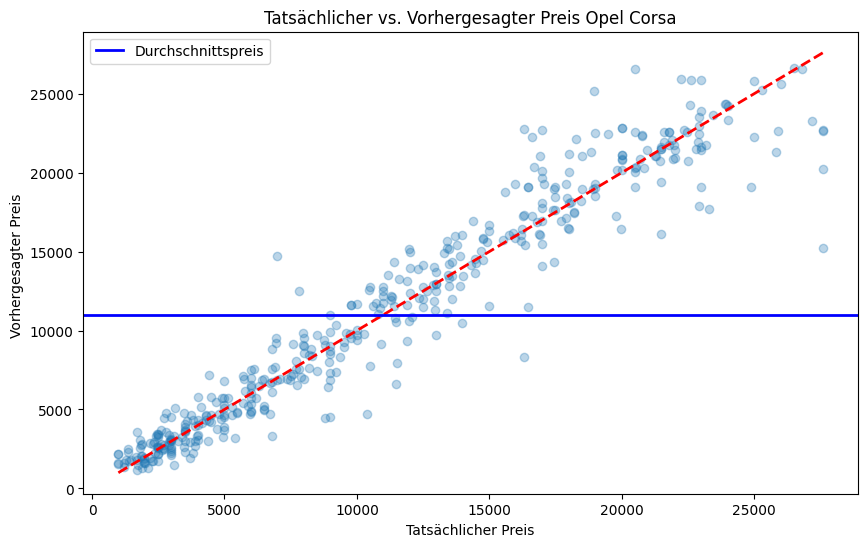

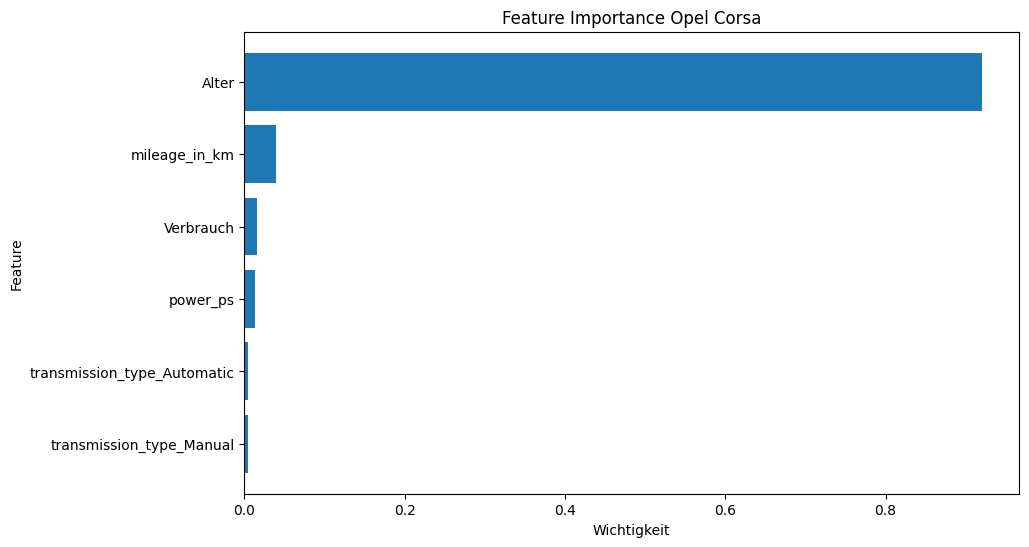

In [8]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

file_path = 'C:\\Desktop\\Datensätze Reg\\DatensatzRegR.csv'

df = pd.read_csv(file_path, delimiter=";")

# kategorische in numerische Variablen umwandeln
df = pd.get_dummies(df, columns=['brand', 'model', 'color', 'transmission_type', 'fuel_type'])

# Filtern des DataFrames nach gewünschtem Automodell
df_filtered = df[(df['model_Opel Corsa'] == 1)]
                 
# Winsorizing der Spalten 'Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', und 'price_in_euro' 
df_filtered['Verbrauch'] = winsorize(df_filtered['Verbrauch'], limits=[0.01, 0.01])
df_filtered['power_ps'] = winsorize(df_filtered['power_ps'], limits=[0.01, 0.01])
df_filtered['Alter'] = winsorize(df_filtered['Alter'], limits=[0.01, 0.01])
df_filtered['mileage_in_km'] = winsorize(df_filtered['mileage_in_km'], limits=[0.01, 0.01])
df_filtered['price_in_euro'] = winsorize(df_filtered['price_in_euro'], limits=[0.01, 0.01])

# Konvertierung der Spalten, die Kommas als Dezimaltrennzeichen verwenden könnten
columns_to_convert = ['Verbrauch', 'Alter']

for column in columns_to_convert:
    if column in df_filtered.columns:
        df_filtered[column] = df_filtered[column].astype(str).str.replace(',', '.').astype(float)

# Begrenzen des Kilometerstandes, Alters und der Preisrange auf vernünftige Bereiche
df_filtered = df_filtered[(df_filtered['mileage_in_km'] >= 0) & (df_filtered['mileage_in_km'] <= 200000)]
df_filtered = df_filtered[(df_filtered['price_in_euro'] >= 500) & (df_filtered['price_in_euro'] <= 70000)]

df_filtered = df_filtered.dropna()

# relevante Features und die Zielvariable auswählen
X = df_filtered[['Verbrauch', 'power_ps', 'Alter', 'mileage_in_km', 'transmission_type_Manual', 'transmission_type_Automatic']]
y = df_filtered['price_in_euro']

# Daten in Trainings- und Testsets aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisiere und trainiere den Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Vorhersagen treffen + Modell bewerten
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
average_price = df_filtered['price_in_euro'].mean()

print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"Durchschnittspreis: {average_price}")


# DF mit den tatsächlichen und den vorhergesagten Werten erstellen
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Feature Importance anzeigen
importance = model.feature_importances_
feature_names = X.columns
feature_importance = pd.DataFrame(list(zip(feature_names, importance)), columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Prediction df + Feature importance ausgeben
print(predictions_df)
print(feature_importance)

# Visualisierung der tatsächlichen gegen die vorhergesagten Werte + Durchschnittswert als Gerade
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red')  # Diagonale Linie
plt.axhline(y=average_price, color='blue', linestyle='-', lw=2, label='Durchschnittspreis')
plt.xlabel('Tatsächlicher Preis')
plt.ylabel('Vorhergesagter Preis ')
plt.title('Tatsächlicher vs. Vorhergesagter Preis Opel Corsa')
plt.legend()
plt.show()

# Visualisierung der Feature Importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance}).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Wichtigkeit')
plt.ylabel('Feature')
plt.title('Feature Importance Opel Corsa')
plt.gca().invert_yaxis()  # Um die wichtigsten Features oben zu haben
plt.show()

#predictions_df.to_excel('C:\\Desktop\\Datensätze Reg\\preddf\\predictionsdf.xlsx')
